# Load the Totality of the Data

#### The data is quite big here, and all of it cannot be loaded at once with a simple read_csv call. 
**A solution is to specify types, to gain memory (for example switching from float64 to float32)**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv']


In [2]:
#libraries
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
print(os.listdir("../input/"))

['sample_submission.csv', 'train.csv', 'test.csv']




Here are the types I use. :
- I load objects as categories, object is fine as well.
- Binary values are switched to int8
- Binary values with missing values are switched to float16 (int does not understand nan), it is possible to use category here as well.
- 64 bits encoding are all switched to 32, or 16 of possible

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', # was 'float32'
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float32', # was 'float16'
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', # was 'float16'
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float64', # was 'float32'
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float64', # was 'float32'
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', # was 'float16'
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', # was 'float16'
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float64', # was 'float32'
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%%time
test_df = pd.read_csv('../input/test.csv', dtype=dtypes)

CPU times: user 3min 22s, sys: 16.2 s, total: 3min 38s
Wall time: 4min 19s


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7853253 entries, 0 to 7853252
Data columns (total 82 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float32
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                         

In [6]:
%%time
train_df = pd.read_csv('../input/train.csv', dtype=dtypes)

CPU times: user 3min 49s, sys: 16.3 s, total: 4min 6s
Wall time: 4min 39s


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
MachineIdentifier                                    category
ProductName                                          category
EngineVersion                                        category
AppVersion                                           category
AvSigVersion                                         category
IsBeta                                               int8
RtpStateBitfield                                     float16
IsSxsPassiveMode                                     int8
DefaultBrowsersIdentifier                            float32
AVProductStatesIdentifier                            float32
AVProductsInstalled                                  float16
AVProductsEnabled                                    float16
HasTpm                                               int8
CountryIdentifier                                    int16
CityIdentifier                         

REDUCE MEMORY USAGE

In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train_df = reduce_mem_usage(train_df)

Mem. usage decreased to 2371.54 Mb (9.1% reduction)


#### Everything is loaded !


In [8]:
train_df['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

In [9]:
train_df.isna().sum()

MachineIdentifier                                          0
ProductName                                                0
EngineVersion                                              0
AppVersion                                                 0
AvSigVersion                                               0
IsBeta                                                     0
RtpStateBitfield                                       32318
IsSxsPassiveMode                                           0
DefaultBrowsersIdentifier                            8488045
AVProductStatesIdentifier                              36221
AVProductsInstalled                                    36221
AVProductsEnabled                                      36221
HasTpm                                                     0
CountryIdentifier                                          0
CityIdentifier                                        325409
OrganizationIdentifier                               2751518
GeoNameIdentifier       

In [10]:
test_df.isna().sum()

MachineIdentifier                                          0
ProductName                                                0
EngineVersion                                              0
AppVersion                                                 0
AvSigVersion                                               0
IsBeta                                                     0
RtpStateBitfield                                       32222
IsSxsPassiveMode                                           0
DefaultBrowsersIdentifier                            7546134
AVProductStatesIdentifier                              23767
AVProductsInstalled                                    23767
AVProductsEnabled                                      23767
HasTpm                                                     0
CountryIdentifier                                          0
CityIdentifier                                        191962
OrganizationIdentifier                               2482129
GeoNameIdentifier       

In [11]:
for col in train_df.columns:
    print(f'"{col}" has {train_df[col].nunique()} unique values and {train_df[col].isna().sum() / len(train_df) * 100:.5f}% NA values.')

"MachineIdentifier" has 8921483 unique values and 0.00000% NA values.
"ProductName" has 6 unique values and 0.00000% NA values.
"EngineVersion" has 70 unique values and 0.00000% NA values.
"AppVersion" has 110 unique values and 0.00000% NA values.
"AvSigVersion" has 8531 unique values and 0.00000% NA values.
"IsBeta" has 2 unique values and 0.00000% NA values.
"RtpStateBitfield" has 7 unique values and 0.36225% NA values.
"IsSxsPassiveMode" has 2 unique values and 0.00000% NA values.
"DefaultBrowsersIdentifier" has 2017 unique values and 95.14164% NA values.
"AVProductStatesIdentifier" has 28970 unique values and 0.40600% NA values.
"AVProductsInstalled" has 8 unique values and 0.40600% NA values.
"AVProductsEnabled" has 6 unique values and 0.40600% NA values.
"HasTpm" has 2 unique values and 0.00000% NA values.
"CountryIdentifier" has 222 unique values and 0.00000% NA values.
"CityIdentifier" has 107366 unique values and 3.64748% NA values.
"OrganizationIdentifier" has 49 unique value

### EXPLORING THE DROPABLE FEATURES

In [10]:
droppable_features = []

garbage collection module

In [11]:
import gc
gc.enable()

In [12]:
gc.collect()

228704

SORTING THE MOSTLY MISSING VALUES

In [16]:
(train_df.isnull().sum()/train_df.shape[0]).sort_values(ascending=False)

PuaMode                                              0.999741
Census_ProcessorClass                                0.995894
DefaultBrowsersIdentifier                            0.951416
Census_IsFlightingInternal                           0.830440
Census_InternalBatteryType                           0.710468
Census_ThresholdOptIn                                0.635245
Census_IsWIMBootEnabled                              0.634390
SmartScreen                                          0.356108
OrganizationIdentifier                               0.308415
SMode                                                0.060277
CityIdentifier                                       0.036475
Wdft_IsGamer                                         0.034014
Wdft_RegionIdentifier                                0.034014
Census_InternalBatteryNumberOfCharges                0.030124
Census_FirmwareManufacturerIdentifier                0.020541
Census_IsFlightsDisabled                             0.017993
Census_F

PuaMode and Census_ProcessorClass have 99percent null values.

In [13]:
droppable_features.append('PuaMode')
droppable_features.append('Census_ProcessorClass')

 Too skewed columns

In [14]:
pd.options.display.float_format = '{:,.4f}'.format
sk_df = pd.DataFrame([{'column': c, 'uniq': train_df[c].nunique(), 'skewness': train_df[c].value_counts(normalize=True).values[0] * 100} for c in train_df.columns])
sk_df = sk_df.sort_values('skewness', ascending=False)
sk_df

,column,skewness,uniq
75,Census_IsWIMBootEnabled,100.0000,2
5,IsBeta,99.9992,2
69,Census_IsFlightsDisabled,99.9990,2
68,Census_IsFlightingInternal,99.9986,2
27,AutoSampleOptIn,99.9971,2
71,Census_ThresholdOptIn,99.9749,2
29,SMode,99.9537,2
65,Census_IsPortableOperatingSystem,99.9455,2
28,PuaMode,99.9134,2
35,Census_DeviceFamily,99.8383,3


There are 12 categorical columns whose majority category covers more than 99% of occurences, and they are useless, too.

In [15]:
droppable_features.extend(sk_df[sk_df.skewness > 99].column.tolist())
droppable_features

['PuaMode',
 'Census_ProcessorClass',
 'Census_IsWIMBootEnabled',
 'IsBeta',
 'Census_IsFlightsDisabled',
 'Census_IsFlightingInternal',
 'AutoSampleOptIn',
 'Census_ThresholdOptIn',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'PuaMode',
 'Census_DeviceFamily',
 'UacLuaenable',
 'Census_IsVirtualDevice']

In [16]:
# PuaMode is duplicated in the two categories.
droppable_features.remove('PuaMode')

In [17]:
# Drop these columns.
train_df.drop(droppable_features, axis=1, inplace=True)

In [18]:
# Nan Values
null_counts = train_df.isnull().sum()
null_counts = null_counts / train_df.shape[0]
null_counts[null_counts > 0.1]

DefaultBrowsersIdentifier    0.9514
OrganizationIdentifier       0.3084
SmartScreen                  0.3561
Census_InternalBatteryType   0.7105
dtype: float64

In [19]:
# Drop these columns.
train_df.drop(['DefaultBrowsersIdentifier','OrganizationIdentifier','SmartScreen','Census_InternalBatteryType'], axis=1, inplace=True)

In [20]:
train_df.isna().sum()

MachineIdentifier                                         0
ProductName                                               0
EngineVersion                                             0
AppVersion                                                0
AvSigVersion                                              0
RtpStateBitfield                                      32318
IsSxsPassiveMode                                          0
AVProductStatesIdentifier                             36221
AVProductsInstalled                                   36221
AVProductsEnabled                                     36221
HasTpm                                                    0
CountryIdentifier                                         0
CityIdentifier                                       325409
GeoNameIdentifier                                       213
LocaleEnglishNameIdentifier                               0
Platform                                                  0
Processor                               

In [21]:
train_df.dropna(inplace=True)
train_df.shape

(7667789, 66)

In [25]:
for col in train_df.columns:
    print(f'"{col}" has {train_df[col].unique()} as unique values\n\n')
    print('-----------------------------------------------------------------------------------------------------------------------------')

"MachineIdentifier" has [0000028988387b115f69f31a3bf04f09, 000007535c3f730efa9ea0b7ef1bd645, 000007905a28d863f6d0d597892cd692, 00000b11598a75ea8ba1beea8459149f, 000014a5f00daa18e76b81417eeb99fc, ..., ffffedd8bc7e8de37f352f3b90694f52, ffffedfe8fcc46e6d36ab39953589fee, fffff8a40070d2d8379bb7fa2ed2fa66, fffffbbaaf5969ae4b93e7f3f6d7132f, ffffff75ba4f33d938ccfdb148b8ea16]
Length: 7667789
Categories (7667789, object): [0000028988387b115f69f31a3bf04f09, 000007535c3f730efa9ea0b7ef1bd645, 000007905a28d863f6d0d597892cd692, 00000b11598a75ea8ba1beea8459149f, ..., ffffedfe8fcc46e6d36ab39953589fee, fffff8a40070d2d8379bb7fa2ed2fa66, fffffbbaaf5969ae4b93e7f3f6d7132f, ffffff75ba4f33d938ccfdb148b8ea16] as unique values


-----------------------------------------------------------------------------------------------------------------------------
"ProductName" has [win8defender, mse, mseprerelease, scep]
Categories (4, object): [win8defender, mse, mseprerelease, scep] as unique values


------------------

### CHECKING FOR DUPLICATES

In [26]:
print("Duplicates in the training dataframe :",train_df.duplicated().sum())

Duplicates in the training dataframe : 0


In [30]:
cols = X_train.columns.tolist()

In [22]:
gc.collect()

42

### EDA

In [34]:
import gc
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
import os
print(os.listdir("../input/"))


['sample_submission.csv', 'train.csv', 'test.csv']


In [52]:
# function to plot data
def plot_categorical_feature(col, only_bars=False, top_n=10, by_touch=False):
    top_n = top_n if train_df[col].nunique() > top_n else train_df[col].nunique()
    print(f"{col} has {train_df[col].nunique()} unique values and type: {train_df[col].dtype}.")
    print(train_df[col].value_counts(normalize=True, dropna=False).head())
    if not by_touch:
        if not only_bars:
            df = train_df.groupby([col]).agg({'HasDetections': ['count', 'mean']})
            df = df.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
            data = [go.Bar(x=df.index, y=df['HasDetections']['count'].values, name='counts'),
                    go.Scatter(x=df.index, y=df['HasDetections']['mean'], name='Detections rate', yaxis='y2')]
            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories and mean target value",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis2=dict(title='Detections rate', overlaying='y', side='right')),
                           legend=dict(orientation="v"))
        else:
            top_cat = list(train_df[col].value_counts(dropna=False).index[:top_n])
            df0 = train_df.loc[(train_df[col].isin(top_cat)) & (train_df['HasDetections'] == 1), col].value_counts().head(10).sort_index()
            df1 = train_df.loc[(train_df[col].isin(top_cat)) & (train_df['HasDetections'] == 0), col].value_counts().head(10).sort_index()
            data = [go.Bar(x=df0.index, y=df0.values, name='Has Detections'),
                    go.Bar(x=df1.index, y=df1.values, name='No Detections')]

            layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories",
                                xaxis = dict(title = f'{col}',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                yaxis = dict(title = 'Counts',
                                             showgrid=False,
                                             zeroline=False,
                                             showline=False,),
                                ),
                           legend=dict(orientation="v"), barmode='group')
        
        py.iplot(dict(data=data, layout=layout))
        
    else:
        top_n = 10
        top_cat = list(train_df[col].value_counts(dropna=False).index[:top_n])
        df = train_df.loc[train[col].isin(top_cat)]

        df1 = train_df.loc[train_df['Census_IsTouchEnabled'] == 1]
        df0 = train_df.loc[train_df['Census_IsTouchEnabled'] == 0]

        df0_ = df0.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df0_ = df0_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        df1_ = df1.groupby([col]).agg({'HasDetections': ['count', 'mean']})
        df1_ = df1_.sort_values(('HasDetections', 'count'), ascending=False).head(top_n).sort_index()
        data1 = [go.Bar(x=df0_.index, y=df0_['HasDetections']['count'].values, name='Nontouch device counts'),
                go.Scatter(x=df0_.index, y=df0_['HasDetections']['mean'], name='Detections rate for nontouch devices', yaxis='y2')]
        data2 = [go.Bar(x=df1_.index, y=df1_['HasDetections']['count'].values, name='Touch device counts'),
                go.Scatter(x=df1_.index, y=df1_['HasDetections']['mean'], name='Detections rate for touch devices', yaxis='y2')]

        layout = go.Layout(dict(title = f"Counts of {col} by top-{top_n} categories for nontouch devices",
                            xaxis = dict(title = f'{col}',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,
                                         type='category'),
                            yaxis = dict(title = 'Counts',
                                         showgrid=False,
                                         zeroline=False,
                                         showline=False,),
                                    yaxis2=dict(title='Detections rate', overlaying='y', side='right'),
                            ),
                       legend=dict(orientation="v"), barmode='group')

        py.iplot(dict(data=data1, layout=layout))
        layout['title'] = f"Counts of {col} by top-{top_n} categories for touch devices"
        py.iplot(dict(data=data2, layout=layout))

Census_IsTouchEnabled has 2 unique values and type: int8.
0   0.8691
1   0.1309
Name: Census_IsTouchEnabled, dtype: float64


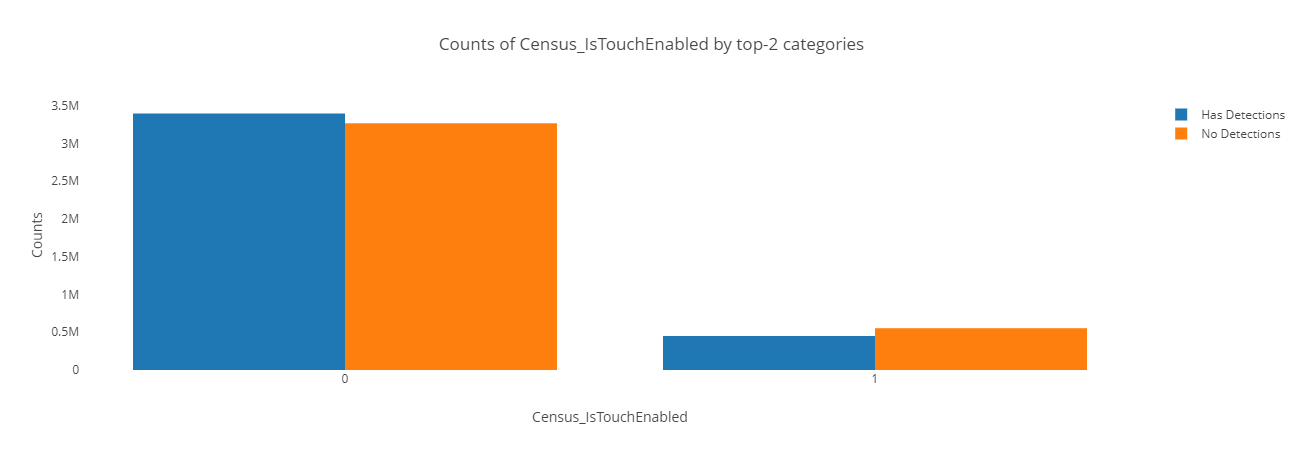

In [53]:
plot_categorical_feature('Census_IsTouchEnabled', True)

As expected Microsoft has much more computers that touch devices. The rate of infections is lower for touch devices, but not by much.

AVProductStatesIdentifier has 25481 unique values and type: float32.
53,447.0000   0.6495
7,945.0000    0.0572
47,238.0000   0.0403
62,773.0000   0.0299
46,413.0000   0.0136
Name: AVProductStatesIdentifier, dtype: float64


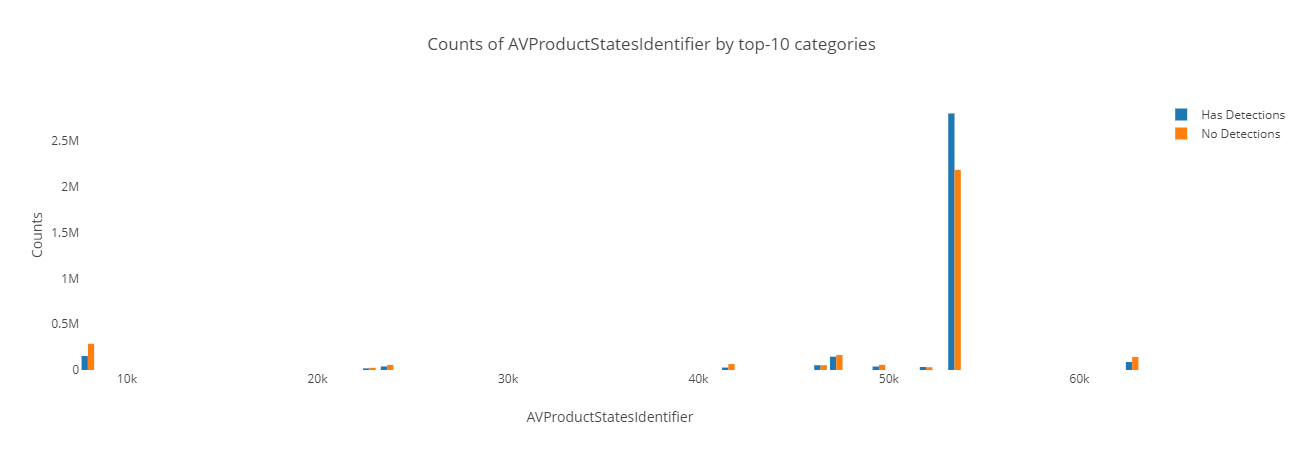

In [54]:
plot_categorical_feature('AVProductStatesIdentifier', True, 10)

In [23]:
train_df['AVProductStatesIdentifier'] = train_df['AVProductStatesIdentifier'].astype('category')

AVProductsInstalled has 7 unique values and type: float16.
1.0000   0.6839
2.0000   0.2900
3.0000   0.0249
4.0000   0.0010
5.0000   0.0001
Name: AVProductsInstalled, dtype: float64


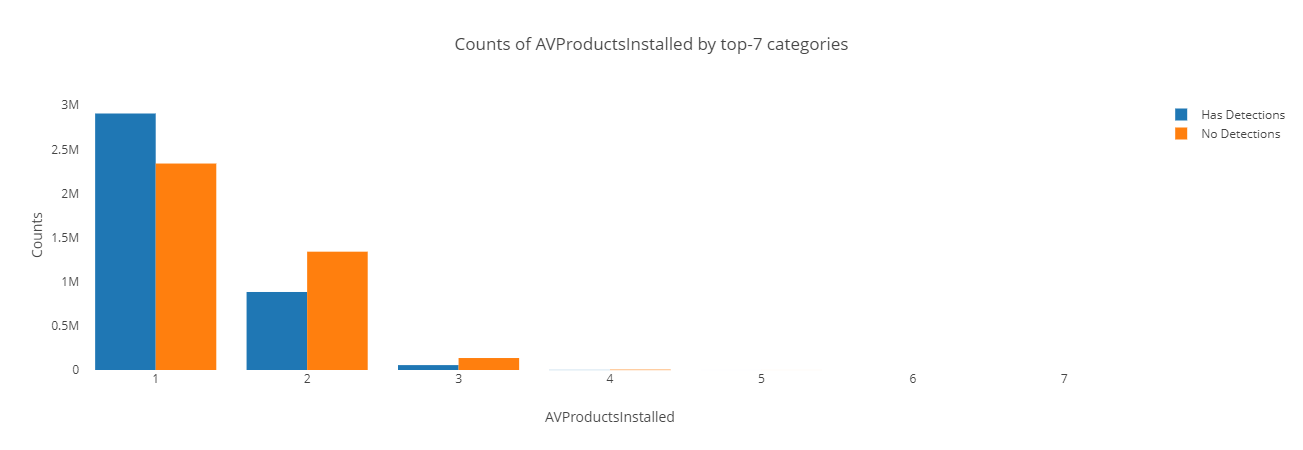

In [56]:
plot_categorical_feature('AVProductsInstalled', True)

In [24]:
train_df['AVProductsInstalled'] = train_df['AVProductsInstalled'].astype('category')

In [25]:
train_df['CountryIdentifier'] = train_df['CountryIdentifier'].astype('category')
train_df['CityIdentifier'] = train_df['CityIdentifier'].astype('category')
#train_df['OrganizationIdentifier'] = train_df['OrganizationIdentifier'].astype('category')
train_df['GeoNameIdentifier'] = train_df['GeoNameIdentifier'].astype('category')
train_df['LocaleEnglishNameIdentifier'] = train_df['LocaleEnglishNameIdentifier'].astype('category')
train_df['IeVerIdentifier'] = train_df['IeVerIdentifier'].astype('category')
train_df['Census_OEMNameIdentifier'] = train_df['Census_OEMNameIdentifier'].astype('category')
train_df['Census_OEMModelIdentifier'] = train_df['Census_OEMModelIdentifier'].astype('category')
train_df['Census_ProcessorModelIdentifier'] = train_df['Census_ProcessorModelIdentifier'].astype('category')
train_df['Census_InternalBatteryNumberOfCharges'] = train_df['Census_InternalBatteryNumberOfCharges'].astype('category')
train_df['Census_OSBuildNumber'] = train_df['Census_OSBuildNumber'].astype('category')
train_df['Census_OSBuildRevision'] = train_df['Census_OSBuildRevision'].astype('category')
train_df['Census_FirmwareManufacturerIdentifier'] = train_df['Census_FirmwareManufacturerIdentifier'].astype('category')
train_df['Census_FirmwareVersionIdentifier'] = train_df['Census_FirmwareVersionIdentifier'].astype('category')
train_df['OsBuild'] = train_df['OsBuild'].astype('category')


In [26]:
def rename_edition(x):
    x = x.lower()
    if 'core' in x:
        return 'Core'
    elif 'pro' in x:
        return 'pro'
    elif 'enterprise' in x:
        return 'Enterprise'
    elif 'server' in x:
        return 'Server'
    elif 'home' in x:
        return 'Home'
    elif 'education' in x:
        return 'Education'
    elif 'cloud' in x:
        return 'Cloud'
    else:
        return x

In [27]:
train_df['Census_OSEdition'] = train_df['Census_OSEdition'].astype(str)
train_df['Census_OSEdition'] = train_df['Census_OSEdition'].apply(rename_edition)
train_df['Census_OSEdition'] = train_df['Census_OSEdition'].astype('category')

In [28]:
train_df['Census_OSSkuName'] = train_df['Census_OSSkuName'].astype(str)
train_df['Census_OSSkuName'] = train_df['Census_OSSkuName'].apply(rename_edition)
train_df['Census_OSSkuName'] = train_df['Census_OSSkuName'].astype('category')

In [29]:
train_df['Census_OSInstallLanguageIdentifier'] = train_df['Census_OSInstallLanguageIdentifier'].astype('category')
train_df['Census_OSUILocaleIdentifier'] = train_df['Census_OSUILocaleIdentifier'].astype('category')
train_df['OsSuite'] = train_df['OsSuite'].astype('category')
train_df['Wdft_RegionIdentifier'] = train_df['Wdft_RegionIdentifier'].astype('category')
train_df['SkuEdition'].value_counts(dropna=False, normalize=True)

Home              0.6381
Pro               0.3500
Education         0.0048
Enterprise        0.0037
Enterprise LTSB   0.0021
Cloud             0.0006
Invalid           0.0006
Server            0.0000
Name: SkuEdition, dtype: float64

In [30]:
train_df.loc[train_df['SkuEdition'] != 'Home', 'SkuEdition'] = 'Pro'

train_df['SkuEdition'] = train_df['SkuEdition'].cat.remove_unused_categories()

In [31]:
pd.crosstab(train_df['SkuEdition'], train_df['Census_OSEdition'], normalize='columns')

Census_OSEdition,Cloud,Core,Education,Enterprise,Home,Server,pro
SkuEdition,,,,,,,
Home,0.0011,0.9958,0.0019,0.0009,0.2000,0.0909,0.0010
Pro,0.9989,0.0042,0.9981,0.9991,0.8000,0.9091,0.9990


In [32]:
train_df['Census_MDC2FormFactor'].value_counts(dropna=False, normalize=True).cumsum()

Notebook       0.6541
Desktop        0.8621
Convertible    0.9108
Detachable     0.9462
AllInOne       0.9773
PCOther        0.9890
LargeTablet    0.9963
SmallTablet    0.9998
SmallServer    0.9999
MediumServer   1.0000
LargeServer    1.0000
IoTOther       1.0000
ServerOther    1.0000
Name: Census_MDC2FormFactor, dtype: float64

In [33]:
top_cats = list(train_df['Census_MDC2FormFactor'].value_counts().index[:5])
train_df.loc[train_df['Census_MDC2FormFactor'].isin(top_cats) == False, 'Census_MDC2FormFactor'] = 'PCOther'

train_df['Census_MDC2FormFactor'] = train_df['Census_MDC2FormFactor'].cat.remove_unused_categories()


Census_MDC2FormFactor has 6 unique values and type: category.
Notebook      0.6541
Desktop       0.2081
Convertible   0.0487
Detachable    0.0354
AllInOne      0.0311
Name: Census_MDC2FormFactor, dtype: float64


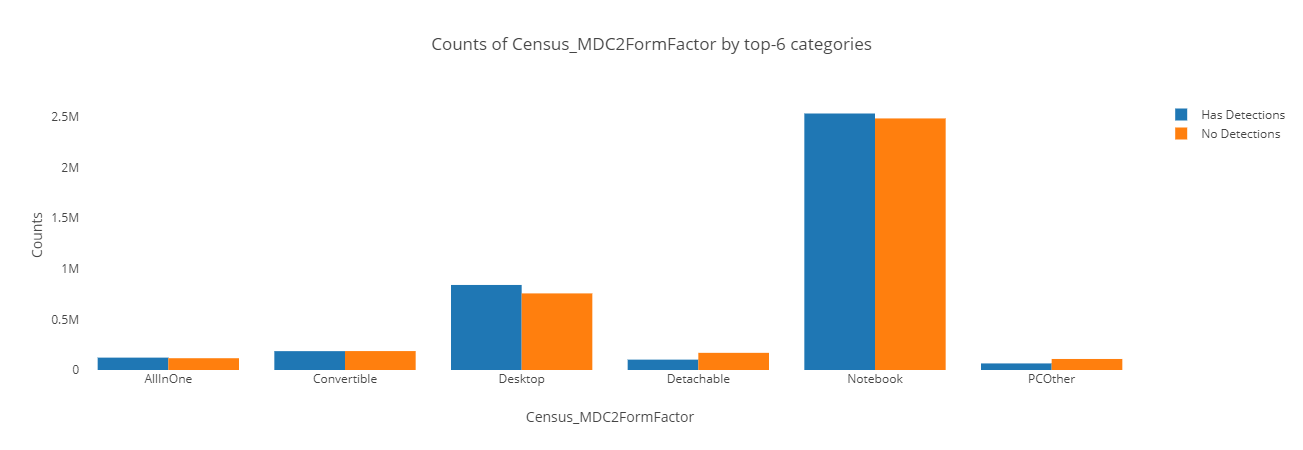

In [74]:
plot_categorical_feature('Census_MDC2FormFactor', True)

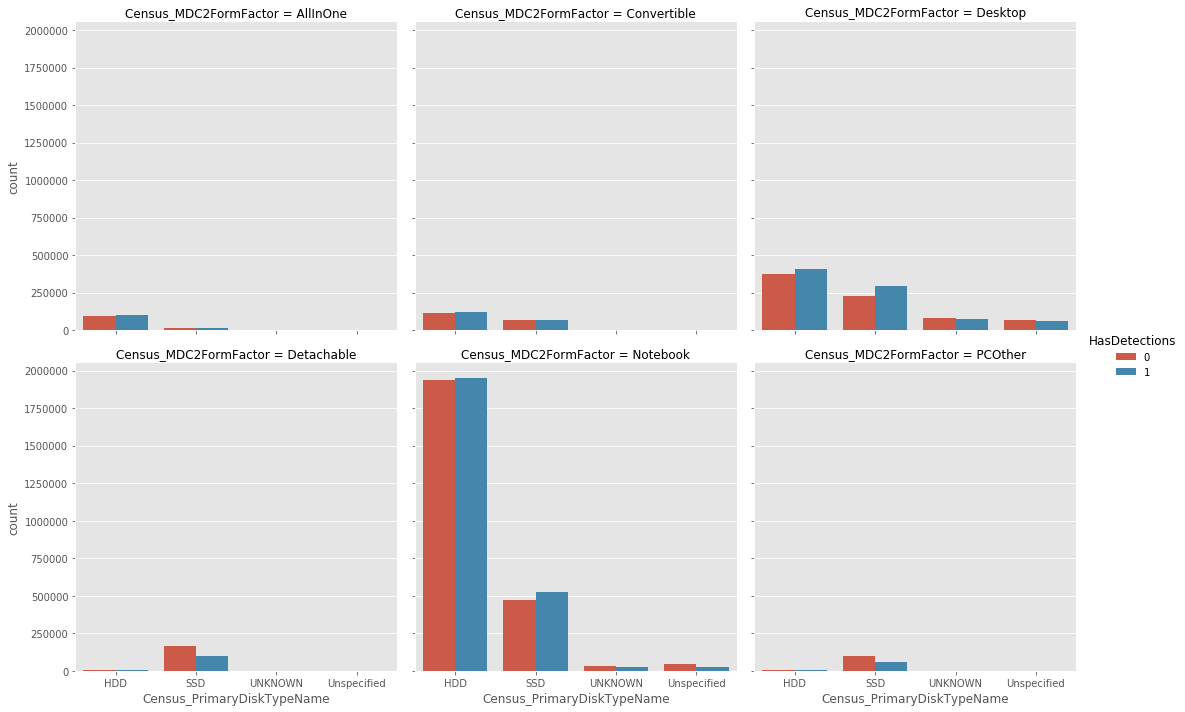

In [75]:
sns.catplot(x="Census_PrimaryDiskTypeName", hue="HasDetections", col="Census_MDC2FormFactor",
                data=train_df, kind="count",col_wrap=3);

In [34]:
train_df['Census_PrimaryDiskTypeName'].value_counts(dropna=False, normalize=True).cumsum()

HDD           0.6681
SSD           0.9436
UNKNOWN       0.9727
Unspecified   1.0000
Name: Census_PrimaryDiskTypeName, dtype: float64

In [35]:
train_df.loc[train_df['Census_PrimaryDiskTypeName'].isin(['HDD', 'SSD']) == False, 'Census_PrimaryDiskTypeName'] = 'UNKNOWN'

train_df['Census_PrimaryDiskTypeName'] = train_df['Census_PrimaryDiskTypeName'].cat.remove_unused_categories()

In [36]:
train_df['Census_ProcessorManufacturerIdentifier'].value_counts(dropna=False, normalize=True).cumsum()

5.0000    0.8820
1.0000    0.9999
10.0000   1.0000
3.0000    1.0000
7.0000    1.0000
4.0000    1.0000
Name: Census_ProcessorManufacturerIdentifier, dtype: float64

In [37]:
train_df.loc[train_df['Census_ProcessorManufacturerIdentifier'].isin([5.0, 1.0]) == False, 'Census_ProcessorManufacturerIdentifier'] = 0.0

train_df['Census_ProcessorManufacturerIdentifier'] = train_df['Census_ProcessorManufacturerIdentifier'].astype('category')

In [38]:
train_df['Census_PowerPlatformRoleName'].value_counts(dropna=False, normalize=True).cumsum()

Mobile              0.7078
Desktop             0.9290
Slate               0.9849
Workstation         0.9947
SOHOServer          0.9986
UNKNOWN             0.9993
AppliancePC         0.9997
EnterpriseServer    1.0000
PerformanceServer   1.0000
Unspecified         1.0000
Name: Census_PowerPlatformRoleName, dtype: float64

In [39]:
train_df.loc[train_df['Census_PowerPlatformRoleName'].isin(['Mobile', 'Desktop', 'Slate']) == False, 'Census_PowerPlatformRoleName'] = 'UNKNOWN'

train_df['Census_PowerPlatformRoleName'] = train_df['Census_PowerPlatformRoleName'].cat.remove_unused_categories()

Census_OSInstallTypeName has 9 unique values and type: category.
UUPUpgrade   0.3166
Update       0.1757
IBSClean     0.1606
Upgrade      0.1474
Other        0.0933
Name: Census_OSInstallTypeName, dtype: float64


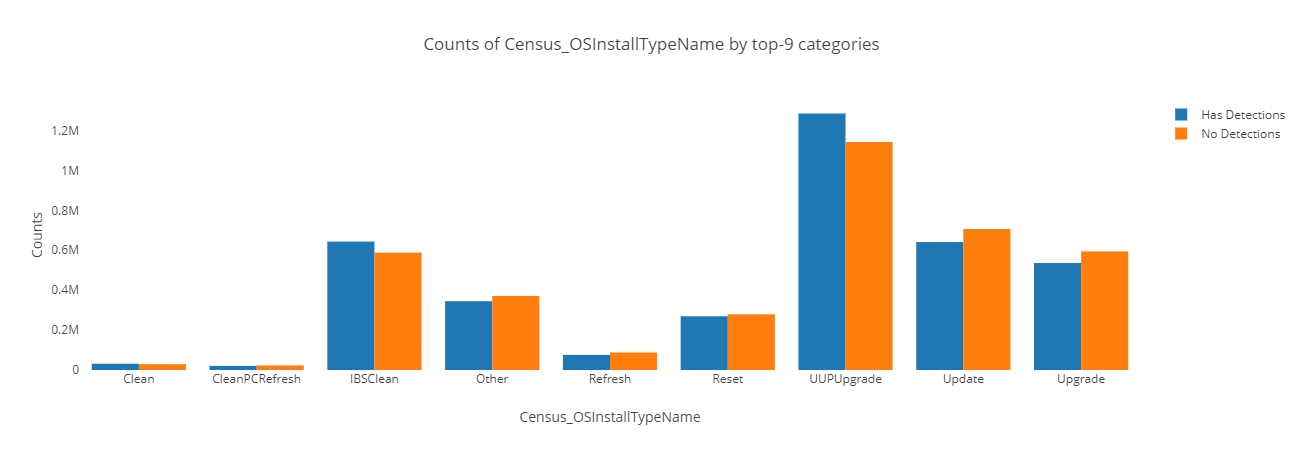

In [85]:
plot_categorical_feature('Census_OSInstallTypeName', True)

In [40]:
top_cats = list(train_df['Census_OSWUAutoUpdateOptionsName'].value_counts().index[:3])
train_df.loc[train_df['Census_OSWUAutoUpdateOptionsName'].isin(top_cats) == False, 'Census_OSWUAutoUpdateOptionsName'] = 'Off'

train_df['Census_OSWUAutoUpdateOptionsName'] = train_df['Census_OSWUAutoUpdateOptionsName'].cat.remove_unused_categories()

In [41]:
train_df.loc[train_df['Census_GenuineStateName'] == 'UNKNOWN', 'Census_GenuineStateName'] = 'OFFLINE'

train_df['Census_GenuineStateName'] = train_df['Census_GenuineStateName'].cat.remove_unused_categories()

In [42]:
train_df.loc[train_df['Census_ActivationChannel'].isin(['Retail', 'OEM:DM']) == False, 'Census_ActivationChannel'] = 'Volume:GVLK'

train_df['Census_ActivationChannel'] = train_df['Census_ActivationChannel'].cat.remove_unused_categories()

### Feature engineering

In [43]:
train_df['OsBuildLab'] = train_df['OsBuildLab'].cat.add_categories(['0.0.0.0.0-0'])
train_df['OsBuildLab'] = train_df['OsBuildLab'].fillna('0.0.0.0.0-0')

In [44]:
def fe(df):
    df['EngineVersion_2'] = df['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['EngineVersion_3'] = df['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AppVersion_1'] = df['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AppVersion_2'] = df['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['AppVersion_3'] = df['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    df['AvSigVersion_0'] = df['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['AvSigVersion_2'] = df['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')

    df['OsBuildLab_0'] = df['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
    df['OsBuildLab_1'] = df['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
    df['OsBuildLab_2'] = df['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
    df['OsBuildLab_3'] = df['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
    # df['OsBuildLab_40'] = df['OsBuildLab'].apply(lambda x: x.split('.')[-1].split('-')[0]).astype('category')
    # df['OsBuildLab_41'] = df['OsBuildLab'].apply(lambda x: x.split('.')[-1].split('-')[1]).astype('category')

    df['Census_OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    df['Census_OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    df['Census_OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    df['Census_OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')

    # https://www.kaggle.com/adityaecdrid/simple-feature-engineering-xd
    df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
    df['non_primary_drive_MB'] = df['Census_PrimaryDiskTotalCapacity'] - df['Census_SystemVolumeTotalCapacity']

    df['aspect_ratio'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']/ df['Census_InternalPrimaryDisplayResolutionVertical']

    df['monitor_dims'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + df['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
    df['monitor_dims'] = df['monitor_dims'].astype('category')

    df['dpi'] = ((df['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + df['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(df['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

    df['dpi_square'] = df['dpi'] ** 2

    df['MegaPixels'] = (df['Census_InternalPrimaryDisplayResolutionHorizontal'] * df['Census_InternalPrimaryDisplayResolutionVertical'])/1e6

    df['Screen_Area'] = (df['aspect_ratio']* (df['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(df['aspect_ratio']**2 + 1)

    df['ram_per_processor'] = df['Census_TotalPhysicalRAM']/ df['Census_ProcessorCoreCount']

    df['new_num_0'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / df['Census_ProcessorCoreCount']

    df['new_num_1'] = df['Census_ProcessorCoreCount'] * df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
    df['Wdft_IsGamer'] = df['Wdft_IsGamer'].fillna(0)
    
    return df

In [45]:
train = fe(train_df)

In [46]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,IeVerIdentifier,Firewall,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,primary_drive_c_ratio,non_primary_drive_MB,aspect_ratio,monitor_dims,dpi,dpi_square,MegaPixels,Screen_Area,ram_per_processor,new_num_0,new_num_1
0,0000028988387b115f69f31a3bf04f09,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0000,0,"53,447.0000",1.0000,1.0000,1,29,"128,035.0000",35.0000,171,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0000,137.0000,1.0000,Desktop,"2,668.0000","9,124.0000",4.0000,5.0000,"2,340.0000","476,940.0000",HDD,"299,451.0000",0,"4,096.0000",Desktop,18.9062,"1,440.0000",900.0000,Desktop,"4,294,967,296.0000",10.0.17134.165,amd64,rs4_release,17134,165,pro,pro,UUPUpgrade,26.0000,119,UNKNOWN,IS_GENUINE,Retail,Retail,628.0000,"36,144.0000",0,0,0,0.0000,0.0000,10.0000,0,15100,1,18,1807,18075,1,273,1735,17134,1,amd64fre,rs4_release,10,0,17134,165,0.6279,"177,489.0000",1.5996,1440.0*900.0,inf,inf,inf,160.7500,"1,024.0000",4.7266,75.6250
1,000007535c3f730efa9ea0b7ef1bd645,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0000,0,"53,447.0000",1.0000,1.0000,1,93,"1,482.0000",119.0000,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0000,137.0000,1.0000,Notebook,"2,668.0000","91,656.0000",4.0000,5.0000,"2,404.0000","476,940.0000",HDD,"102,385.0000",0,"4,096.0000",Notebook,13.8984,"1,366.0000",768.0000,Mobile,1.0000,10.0.17134.1,amd64,rs4_release,17134,1,pro,pro,IBSClean,8.0000,31,UNKNOWN,OFFLINE,Retail,NOT_SET,628.0000,"57,858.0000",0,0,0,0.0000,0.0000,8.0000,0,14600,4,13,17134,1,1,263,48,17134,1,amd64fre,rs4_release,10,0,17134,1,0.2147,"374,555.0000",1.7783,1366.0*768.0,inf,inf,inf,82.5000,"1,024.0000",3.4746,55.5938
2,000007905a28d863f6d0d597892cd692,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0000,0,"53,447.0000",1.0000,1.0000,1,86,"153,579.0000",64.0000,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0000,137.0000,1.0000,Desktop,"4,908.0000","317,701.0000",4.0000,5.0000,"1,972.0000","114,473.0000",SSD,"113,907.0000",0,"4,096.0000",Desktop,21.5000,"1,920.0000","1,080.0000",Desktop,"4,294,967,296.0000",10.0.17134.165,amd64,rs4_release,17134,165,Core,Core,UUPUpgrade,7.0000,30,FullAuto,IS_GENUINE,Volume:GVLK,Retail,142.0000,"52,682.0000",0,0,0,0.0000,0.0000,3.0000,0,15100,1,18,1807,18075,1,273

In [47]:
more_cat_cols = []
add_cat_feats = [
 'Census_OSBuildRevision',
 'OsBuildLab',
 'SmartScreen',
'AVProductsInstalled']
for col1 in add_cat_feats:
    for col2 in add_cat_feats:
        if col1 != col2:
            try:
                train[col1 + '__' + col2] = train[col1].astype(str) + train[col2].astype(str)
            except Exception as e:
                pass
            try:
                train[col1 + '__' + col2] = train[col1 + '__' + col2].astype('category')
            except Exception as e:
                pass
            
            more_cat_cols.append(col1 + '__' + col2)


In [48]:
cat_cols = [col for col in train.columns if col not in ['MachineIdentifier', 'Census_SystemVolumeTotalCapacity', 'HasDetections'] and str(train[col].dtype) == 'category']
len(cat_cols)

68

In [49]:
cat_cols = cat_cols + more_cat_cols

In [50]:
cat_cols

['ProductName',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'CountryIdentifier',
 'CityIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IeVerIdentifier',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel

### ENCODING

In [52]:
to_encode = []
for col in cat_cols:
    try:
        if train[col].nunique() > 1000:
            print(col, train[col].nunique())
            to_encode.append(col)
    except Exception as e:
        pass

AvSigVersion 8476
AVProductStatesIdentifier 25481
CityIdentifier 103914
Census_OEMNameIdentifier 2350
Census_OEMModelIdentifier 161112
Census_ProcessorModelIdentifier 2340
Census_InternalBatteryNumberOfCharges 38557
Census_FirmwareVersionIdentifier 46681
AvSigVersion_2 2755
monitor_dims 4530
Census_OSBuildRevision__OsBuildLab 10000
OsBuildLab__Census_OSBuildRevision 10000
OsBuildLab__AVProductsInstalled 1348
AVProductsInstalled__OsBuildLab 1348
Census_OSBuildRevision__OsBuildLab 10000
OsBuildLab__Census_OSBuildRevision 10000
OsBuildLab__AVProductsInstalled 1348
AVProductsInstalled__OsBuildLab 1348


In [53]:
train = reduce_mem_usage(train)
gc.collect()

Mem. usage decreased to 2590.89 Mb (-6.0% reduction)


63

In [56]:
def frequency_encoding(variable):
    t = train[variable].value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [57]:
for col in tqdm_notebook(to_encode):
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

Label Encoding

In [59]:
%%time
indexer = {}
for col in cat_cols:
    try:
    
        print(col)
        _, indexer[col] = pd.factorize(train[col].astype(str), sort=True)
    except Exception as e:
        pass
    
for col in tqdm_notebook(cat_cols):
    try:
        # print(col)
        train[col] = indexer[col].get_indexer(train[col].astype(str))
    except Exception as e:
        pass
    
    train = reduce_mem_usage(train, verbose=False)

ProductName
EngineVersion
AppVersion
AVProductsInstalled
CountryIdentifier
GeoNameIdentifier
LocaleEnglishNameIdentifier
Platform
Processor
OsVer
OsBuild
OsSuite
OsPlatformSubRelease
OsBuildLab
SkuEdition
IeVerIdentifier
Census_MDC2FormFactor
Census_ProcessorManufacturerIdentifier
Census_PrimaryDiskTypeName
Census_ChassisTypeName
Census_PowerPlatformRoleName
Census_OSVersion
Census_OSArchitecture
Census_OSBranch
Census_OSBuildNumber
Census_OSBuildRevision
Census_OSEdition
Census_OSSkuName
Census_OSInstallTypeName
Census_OSInstallLanguageIdentifier
Census_OSUILocaleIdentifier
Census_OSWUAutoUpdateOptionsName
Census_GenuineStateName
Census_ActivationChannel
Census_FlightRing
Census_FirmwareManufacturerIdentifier
Wdft_RegionIdentifier
EngineVersion_2
EngineVersion_3
AppVersion_1
AppVersion_2
AppVersion_3
AvSigVersion_0
AvSigVersion_1
OsBuildLab_0
OsBuildLab_1
OsBuildLab_2
OsBuildLab_3
Census_OSVersion_0
Census_OSVersion_1
Census_OSVersion_2
Census_OSVersion_3
Census_OSBuildRevision__AVPro


CPU times: user 21min 50s, sys: 25.6 s, total: 22min 16s
Wall time: 22min 14s


In [60]:
del indexer

In [1]:
train.head()

NameError: name 'train' is not defined

In [61]:
train.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,IeVerIdentifier,Firewall,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,EngineVersion_2,EngineVersion_3,AppVersion_1,AppVersion_2,AppVersion_3,AvSigVersion_0,AvSigVersion_1,AvSigVersion_2,OsBuildLab_0,OsBuildLab_1,OsBuildLab_2,OsBuildLab_3,Census_OSVersion_0,Census_OSVersion_1,Census_OSVersion_2,Census_OSVersion_3,primary_drive_c_ratio,non_primary_drive_MB,aspect_ratio,monitor_dims,dpi,dpi_square,MegaPixels,Screen_Area,ram_per_processor,new_num_0,new_num_1,Census_OSBuildRevision__OsBuildLab,Census_OSBuildRevision__AVProductsInstalled,OsBuildLab__Census_OSBuildRevision,OsBuildLab__AVProductsInstalled,AVProductsInstalled__Census_OSBuildRevision,AVProductsInstalled__OsBuildLab
0,0000028988387b115f69f31a3bf04f09,3,60,59,77.0000,7.0000,0,0.0000,0,1.0000,1,144,211.0000,221,80,0,1,0,6,0,4,257,1,1.0000,18,1.0000,2,0.0000,"36,436.0000",4.0000,2,147.0000,"476,940.0000",0,"299,451.0000",0,"4,096.0000",19,18.9062,"1,440.0000",900.0000,0,1.0000,334,0,9,84,74,6,5,6,18,15,3,1,1,5,403,"2,544.0000",0,0,0,0.0000,0.0000,1,0,54,1,8,25,53,1,43,84.0000,17,1,0,12,0,0,84,74,0.6279,"177,489.0000",1.5996,6.0000,inf,inf,inf,160.7500,"1,024.0000",4.7266,75.6250,1.0000,-1,1.0000,0.0000,-1,0.0000
1,000007535c3f730efa9ea0b7ef1bd645,3,50,26,11.0000,7.0000,0,0.0000,0,1.0000,1,215,163.0000,22,236,0,1,0,6,0,4,257,1,1.0000,18,1.0000,4,0.0000,"89,229.0000",4.0000,2,246.0000,"476,940.0000",0,"102,385.0000",0,"4,096.0000",32,13.8984,"1,366.0000",768.0000,1,2.0000,330,0,9,84,1,6,5,2,37,76,3,2,1,2,403,"1,939.0000",0,0,0,0.0000,0.0000,13,0,49,4,3,6,1,1,38,7.0000,17,1,0,12,0,0,84,1,0.2147,"374,555.0000",1.7783,0.0000,inf,inf,inf,82.5000,"1,024.0000",3.4746,55.5938,23.0000,-1,23.0000,0.0000,-1,0.0000
2,000007905a28d863f6d0d597892cd692,3,60,59,178.0000,7.0000,0,0.0000,0,1.0000,1,207,693.0000,252,220,0,1,0,6,2,4,257,0,1.0000,18,1.0000,2,11.0000,2.0000,4.0000,2,195.0000,"114,473.0000",1,"113,907.0000",0,"4,096.0000",19,21.5000,"1,920.0000","1,080.0000",0,1.0000,334,0,9,84,74,1,1,6,36,75,0,1,2,5,80,199.0000,0,0,0,0.0000,0.0000,8,0,54,1,8,25,53,1,43,126.0000,17,1,0,12,0,0,84,74,0.9951,566.0000,1.7773,1.0000,inf,inf,inf,197.6250,"1,024.0000",5.3750,86.0000,1.0000,-1,1.0000,0.0000,-1,0.0000
3,00000b11598a75ea8ba1beea8459149f,3,60,59,16.0000,7.0000,0,0.0000,0,1.0000,1,209,20.0000,20,18,0,1,0,6,0,4,257,1,1.0000,18,1.0000,2,2.0000,176.0000,4.0000,2,66.0000,"238,475.0000",2,"227,116.0000",0,"4,096.0000",30,18.5000,"1,366.0000",768.0000,0,1.0000,338,0,9,84,151,6,5,6,8,109,0,1,2,5,212,34.0000,0,0,0,0.0000,0.0000,8,1,54,1,8,25,53,1,43,12.0000,17,1,0,12,0,0,84,151,0.9521,"11,359.0000",1.7783,0.0000,inf,inf,in

## MODELING

We fit a LightGradident Boosting Model on our training dataframe

#### What is Gradient Boosting?
Gradient boosting is an iterative algorithm that builds a model in a forward stage-wise fashion. It starts by fitting a simple model, such as a decision tree, to the data and then adds additional models to correct the errors made by the previous models. Each new model is fit to the negative gradient of the loss function with respect to the previous model’s predictions. The final model is a weighted sum of all the individual models.

#### What is the LGBM Model?
LightGBM is a gradient boosting ensemble method that is used by the Train Using AutoML tool and is based on decision trees. As with other decision tree-based methods, LightGBM can be used for both classification and regression. LightGBM is optimized for high performance with distributed systems.

#### Why Light GBM? Why not GBM?
GBMs are powerful machine learning models that have been shown to outperform many other types of models, including deep neural networks, in a variety of tasks. LightGBM uses a novel technique called histogram-based binning allowing it to learn from data more efficiently than traditional GBMs.

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


In [65]:
del train_df

In [63]:
train = train.drop(['MachineIdentifier'], axis=1)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(train, train['HasDetections'], test_size = 0.2, random_state = 42)

In [ ]:
parameters = {
              'n_estimators' : [500, 600], 'max_depth' : [7, 8],
              'colsample_bytree' : [0.6, 0.7], 'num_leaves' : [70, 80]
             }

clf = lgb.LGBMClassifier(learning_rate = 0.1)
grid_search_clf = GridSearchCV(clf, parameters, verbose = 2)
grid_search_clf.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70 
[CV]  colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70, total= 7.9min
[CV] colsample_bytree=0.6, max_depth=7, n_estimators=500, num_leaves=70 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.0min remaining:    0.0s


In [ ]:
print("These are the best parameters from grid search -")
grid_search_clf.best_params_

In [ ]:
clf_lgbm = grid_search_clf.best_estimator_

In [ ]:
clf_lgbm.fit(X_train_encoded, y_train,
           eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)],
           eval_names = ['train', 'val'],
           eval_metric ='auc',
           callbacks = [lgb.log_evaluation(50), lgb.early_stopping(5)])

In [ ]:
plt.figure(figsize=(14, 5))
train_auc = clf_lgbm.evals_result_['train']['auc']
val_auc = clf_lgbm.evals_result_['val']['auc']

plt.subplot(1,2,1)
plt.plot(train_auc,  'bo', label = 'Training AUC')
plt.plot(val_auc,  'r', label = 'Validation AUC')
plt.title('Light Gradient Boosting : Area Under Curve')
plt.legend()


train_loss = clf_lgbm.evals_result_['train']['binary_logloss']
val_loss = clf_lgbm.evals_result_['val']['binary_logloss']
plt.subplot(1,2,2)
plt.plot(train_loss, 'bo', label = 'Trainig loss')
plt.plot(val_loss, 'r', label = 'Validation loss')
plt.title('Light Gradient Boosting : Binary Log-Loss')
plt.legend()
    
plt.show()